# Intersect property data with flooding data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd
import rioxarray as rx
import matplotlib.pyplot as plt
import re
from pathlib import Path
from dbfread import DBF
import janitor
import seaborn as sns

In [3]:
# data paths
RAW_DATA = "../data/raw/"
CLEAN_DATA = "../data/clean/"
SLAMM_RESULTS = CLEAN_DATA + "slamm/"
OUTPUT = "../output/"

Read in and merge MA property data

In [4]:
# merge property data together
def merge_prop(taxpar_gdf, assessor, use_type):
    assess_gdf = taxpar_gdf.merge(assessor, on = 'LOC_ID', how = 'left')
    assess_gdf = assess_gdf[['LOC_ID', 'OWNER1', 'BLDG_VAL', 'LAND_VAL', 'TOTAL_VAL', 'USE_CODE', 'YEAR_BUILT', 'STORIES', 'geometry']]
    prop = assess_gdf.merge(use_type, on='USE_CODE', how ='left')
    prop['area_m2'] = prop.geometry.area
    return prop

In [5]:
# read in the property data and merge
def get_town_props(folder_path):

    # Compile the regular expression pattern
    taxpar = re.compile('taxpar', re.IGNORECASE)
    assess = re.compile('assess', re.IGNORECASE)
    use_type = re.compile('uc_lut', re.IGNORECASE)
    
    # Create a Path object for the folder
    path = Path(folder_path)
    
    if not path.is_dir():
        print(f"The folder at {folder_path} does not exist or is not a directory.")
        return None

    # Iterate through files in the directory
    for file in path.iterdir():
        if file.is_file():
            # Check if the file name matches the pattern
            if taxpar.search(file.name) and file.suffix == '.shp':
                    taxpar_file = gpd.read_file(file)
            if assess.search(file.name) and file.suffix == '.dbf':
                    dbf = DBF(file)
                    assess_file = pd.DataFrame(iter(dbf))
            if use_type.search(file.name) and file.suffix == '.dbf':
                    dbf = DBF(file)
                    use_type_file = pd.DataFrame(iter(dbf))

    town_props = merge_prop(taxpar_file, assess_file, use_type_file)

    # add a column for the town name
    town_props[['town_name']] = folder_path.split('_')[-1].strip('/')
            
    return town_props

In [6]:
falmouth_props = get_town_props(RAW_DATA + 'properties/L3_SHP_M096_Falmouth/')

In [11]:
# CC-1 properties
falmouth_props = get_town_props(RAW_DATA + 'properties/L3_SHP_M096_Falmouth/')
mashpee_props = get_town_props(RAW_DATA + 'properties/L3_SHP_M172_Mashpee/')
cc1_props = pd.concat([falmouth_props, mashpee_props])

In [12]:
# MA-2 properties
bourne_props = get_town_props(RAW_DATA + 'properties/L3_SHP_M036_Bourne/')
marion_props = get_town_props(RAW_DATA + 'properties/L3_SHP_M169_Marion/')
wareham_props = get_town_props(RAW_DATA + 'properties/L3_SHP_M310_Wareham/')
plymouth_props = get_town_props(RAW_DATA + 'properties/L3_SHP_M239_Plymouth/') 
rochester_props = get_town_props(RAW_DATA + 'properties/L3_SHP_M250_Rochester/')
ma2_props = pd.concat([bourne_props, marion_props, wareham_props, plymouth_props, rochester_props])

In [14]:
# Residential use types we want to look at for housing
ma_hous_type_keep = [
    'Single Family Residential',
    'Mixed Use (Primarily Residential, some Commercial)',
    'Mixed Use (Primarily Residential, some Agriculture)',
    'Housing, Other (Charitable Org.)',
    'Two-Family Residential',
    'Residential Condominium',
    'Three-Family Residential',
    'Mixed Use (Primarily Residential, some Industrial)',
    'Other Congregate Housing (includes non-transient shared living arrangements)'
]

In [15]:
cc1_res = cc1_props[cc1_props['USE_DESC'].isin(ma_hous_type_keep)]
ma2_res = ma2_props[ma2_props['USE_DESC'].isin(ma_hous_type_keep)]

In [29]:
ma2_res[['LOC_ID', 'FY']].groupby('FY').count().reset_index()

,FY,LOC_ID
0,2021.0,9179
1,2023.0,34163
2,2024.0,4167


In [30]:
cc1_res[['LOC_ID', 'FY']].groupby('FY').count().reset_index()

,FY,LOC_ID
0,2022.0,20386
1,2024.0,10150


In [36]:
cc1_res.to_file(CLEAN_DATA + 'properties/cc1_res.geojson')
ma2_res.to_file(CLEAN_DATA + 'properties/ma2_res.geojson')

Read in and clean RI property data

In [19]:
# RI parcel data
barrington_parcels = gpd.read_file(RAW_DATA + "properties/BarringtonRI-1727877177084/ParcelPoly.shp")

In [9]:
# get MA property data that touches the RI marsh
swansea_props = get_town_props(RAW_DATA + 'properties/L3_SHP_M292_Swansea/')
seekonk_props = get_town_props(RAW_DATA + 'properties/L3_SHP_M265_Seekonk/')
ri2_ma_props = pd.concat([swansea_props, seekonk_props]).to_crs(barrington_parcels.crs)
ri2_ma_res_crs = ri2_ma_props[ri2_ma_props['USE_DESC'].isin(ma_hous_type_keep)]


In [10]:
ri_marsh = gpd.read_file(CLEAN_DATA + 'chosen_saltmarshes/ri2_vegtype.shp').to_crs(barrington_parcels.crs)

[]

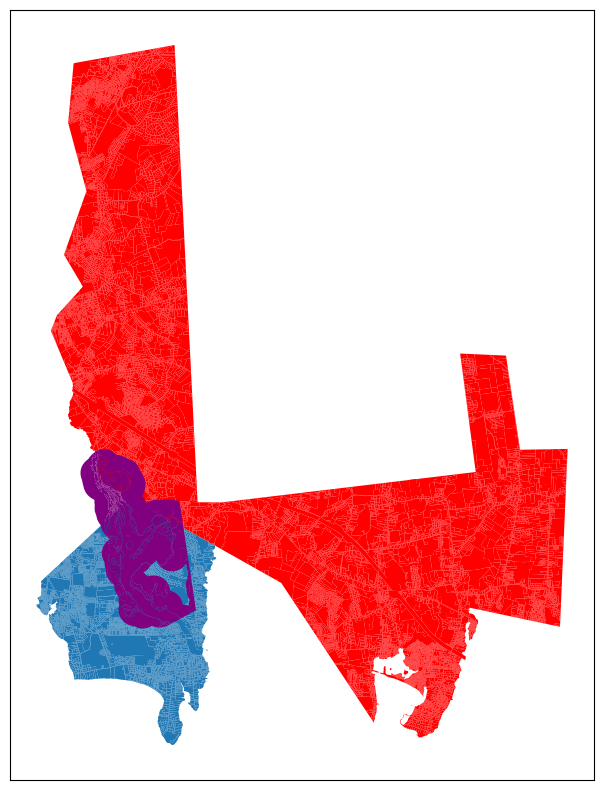

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))
barrington_parcels.plot(ax=ax)
ri2_ma_props.plot(ax=ax, color='red')
ri_marsh.plot(ax=ax, color='purple')
ax.set_xticks([])
ax.set_yticks([])


In [12]:
ri_hous_type_keep = [
    '2 Family',
    '3 Family',
    '4 Family',
    'Antique',
    'Apt',
    'Assist Liv'
    'Bungalow',
    'Cape',
    'Cape Condo',
    'Colonial',
    'Colonial Con',
    'Condominium',
    'Contemporary',
    'Conventional',
    'Cottage',
    'Dormitories',
    'GroupCareHm',
    'Home/Elderly',
    'Log Cabin',
    'R Ranch',
    'Rectory',
    'Rnch',
    'Rnch-F/B',
    'Rnch-Slab',
    'Split Level'
]

In [20]:
# filter to just residential properties
barrington_just_parcels = barrington_parcels[barrington_parcels.Type == 'PARCEL']
barrington_res = barrington_just_parcels[barrington_just_parcels.BuildType.isin(ri_hous_type_keep)]
barrington_res = barrington_res[['Parcel_Num', 'TotalBuild', 'TotalLandV',  'TotalValue', 'geometry']]
barrington_res[['town_name']] = 'Barrington'

In [21]:
# combine RI property data with MA property data
ri2_ma_res_simp = ri2_ma_res_crs[['town_name', 'LOC_ID', 'BLDG_VAL',	'LAND_VAL',	'TOTAL_VAL', 'geometry']]
barrington_res.rename(columns={'Parcel_Num': 'LOC_ID', 'TotalBuild': 'BLDG_VAL', 'TotalLandV': 'LAND_VAL',  'TotalValue': 'TOTAL_VAL'}, inplace=True)
ri2_res = pd.concat([ri2_ma_res_simp, barrington_res])

In [23]:
ri2_res.to_file(CLEAN_DATA + 'properties/ri2_res.geojson')

<Axes: >

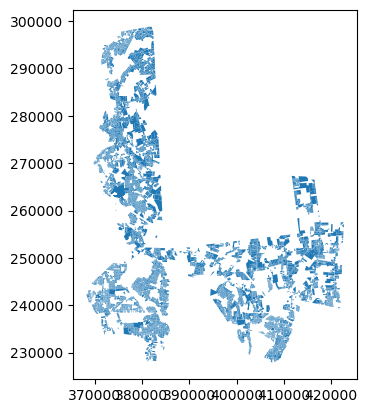

In [15]:
ri2_res.plot()

Calculate the total housing value in each town

In [16]:
def calc_total_val(res_path):
    marsh_res = gpd.read_file(res_path)
    marsh_res['marsh'] = res_path.split('/')[-1].split('_')[0]
    res_val = marsh_res.groupby('town_name').agg(
        {
        'marsh': 'first',
         'BLDG_VAL': 'sum',
         'LAND_VAL': 'sum',  
         'TOTAL_VAL': 'sum' 
         }
         ).reset_index()
    
    return res_val

In [43]:
cc1_res_val = calc_total_val(CLEAN_DATA + 'properties/cc1_res.geojson')
ma2_res_val = calc_total_val(CLEAN_DATA + 'properties/ma2_res.geojson')
ma_res_val = pd.concat([cc1_res_val, ma2_res_val])
ma_res_val.to_csv(CLEAN_DATA + 'properties/ma_res_val.csv')

In [24]:
ri2_res_val = calc_total_val(CLEAN_DATA + 'properties/ri2_res.geojson')
ri2_res_val
ri2_res_val.to_csv(CLEAN_DATA + 'properties/ri2_res_val.csv')

,town_name,marsh,BLDG_VAL,LAND_VAL,TOTAL_VAL
0,Barrington,ri2,1.571483e+09,1.332270e+09,2.921494e+09
1,Seekonk,ri2,1.721342e+09,8.995263e+08,2.620868e+09
2,Swansea,ri2,1.596964e+09,8.749030e+08,2.499869e+09


Intersect with the flooding data

In [26]:
import glob
from tqdm.auto import tqdm

c:\Users\AMarley.ERG\.conda\envs\geospatial-new\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
cc1_res = gpd.read_file(CLEAN_DATA + 'properties/cc1_res.geojson')
ma2_res = gpd.read_file(CLEAN_DATA + 'properties/ma2_res.geojson')
ri2_res = gpd.read_file(CLEAN_DATA + 'properties/ri2_res.geojson')

In [28]:
# function to intersect the flooding geodataframe with the properties data
def intersect_res(inun_path: gpd.GeoDataFrame, intersect_gdf: gpd.GeoDataFrame, inun_freq_key: pd.DataFrame):
    inun_gdf = gpd.read_file(inun_path)
    inun_gdf = inun_gdf.to_crs(intersect_gdf.crs)
    intersected = gpd.overlay(intersect_gdf, inun_gdf, how='intersection')
    intersected.drop('geometry', axis = 1, inplace=True)
    
    # get the most intense flooding for each property
    res_most_affect = intersected.groupby(by = 'LOC_ID').agg(
        {'year': 'first', 
         'marsh': 'first',
         'inun_freq_code': 'min',
         'BLDG_VAL': 'first',
         'LAND_VAL': 'first',
         'TOTAL_VAL': 'first' 
         }
         ).reset_index()
    
    # sum and count for each inundation type
    total_props = res_most_affect.groupby(by = 'inun_freq_code').agg(
        {'year': 'first', 
         'marsh': 'first',
         'LOC_ID': 'count',
         'BLDG_VAL': 'sum',
         'LAND_VAL': 'sum',  
         'TOTAL_VAL': 'sum' 
         }
         ).reset_index()
    
    total_props.rename({'LOC_ID': 'num_props_affect', 'BLDG_VAL': 'bldg_val', 'LAND_VAL': 'land_val', 'TOTAL_VAL': 'total_val'}, axis=1, inplace=True)
    total_props = total_props.merge(inun_freq_key, on='inun_freq_code', how='left')
    total_props = total_props[['inun_freq_code', 'inun_freq', 'year', 'marsh', 'num_props_affect', 'bldg_val', 'land_val', 'total_val']]

    return total_props

In [32]:
# function to intersect the flooding geodataframe with the properties data and multiply the property value by the percentage
# of the property that is flooded
def intersect_res_perc(inun_path: gpd.GeoDataFrame, intersect_gdf: gpd.GeoDataFrame, inun_freq_key: pd.DataFrame):
    
    inun_gdf = gpd.read_file(inun_path)
    inun_gdf = inun_gdf.to_crs(intersect_gdf.crs)
    intersect_gdf['area_m2'] = intersect_gdf.geometry.area

    # calculate fraction of parcel flooded
    intersected = gpd.overlay(intersect_gdf, inun_gdf, how='intersection')
    intersected['intersect_area'] = intersected.geometry.area
    intersected['fract_inundated'] = intersected['intersect_area'] / intersected['area_m2']
    intersected.drop('geometry', axis = 1, inplace=True)

    # multiply the fraction inundated by the property values
    intersected['bldg_val_af'] = intersected['BLDG_VAL'] * intersected['fract_inundated']
    intersected['land_val_af'] = intersected['LAND_VAL'] * intersected['fract_inundated']
    intersected['ttl_val_af'] = intersected['TOTAL_VAL'] * intersected['fract_inundated']

    # sum and count for each inundation type
   # total_props = intersected.groupby(by = 'inun_freq_code').agg(
   #     {'year': 'first', 
   #      'marsh': 'first',
   #      'bldg_val_af': 'sum',
   #      'land_val_af': 'sum',  
   #      'ttl_val_af': 'sum' 
   #      }
   #      ).reset_index()
    
  #  total_props = total_props.merge(inun_freq_key, on='inun_freq_code', how='left')

   # return total_props

    intersected = intersected.merge(inun_freq_key, on='inun_freq_code', how='left')

    return intersected

In [30]:
# Make inundation frequency key to add to dataframe
inun_freq_key_list = [
    [0, 'always inundated'], 
    [1, '30-day inundation'], 
    [2, '60-day inundation'], 
    [3, '90-day inundation'], 
    [4, '10-year storm'], 
    [5, '100-year storm'], 
    [8, 'protected by dikes']
]

inun_freq_key_df = pd.DataFrame(inun_freq_key_list, columns=['inun_freq_code', 'inun_freq'])

In [33]:
FILE_PATH_PATTERN = re.compile(r"(cc1|ma2|ri2)\/.*(1|2)slr_.*(20|70|40)_(n|s).*\.geojson", re.IGNORECASE)
pbar = tqdm(glob.glob(f"{SLAMM_RESULTS}/*/*.geojson"))

ri2_combined=None
for fpath in pbar:
    fpath = fpath.replace("\\", "/")
    pbar.set_description(f"Processing {fpath.split('/')[-1]}")
    match = FILE_PATH_PATTERN.search(fpath)
    if match is None:
        continue
    marsh_id = match.group(1)
    slr_scenario = match.group(2)

    if marsh_id == 'cc1':
        continue

    if marsh_id == 'ma2':
        continue

    if marsh_id == 'ri2':
        intersected_ri2 = intersect_res_perc(fpath, ri2_res, inun_freq_key_df)
        intersected_ri2['slr_m'] = slr_scenario
        if ri2_combined is None:
            ri2_combined = intersected_ri2
        else:
            ri2_combined = pd.concat([ri2_combined, intersected_ri2])
        
ri2_combined.to_csv(SLAMM_RESULTS + 'intersections/ri2_homes_flooded_all.csv')

Processing ri2_2slr_70_sm_00.geojson: 100%|██████████| 35/35 [14:31<00:00, 24.91s/it] 


In [ ]:
FILE_PATH_PATTERN = re.compile(r"(cc1|ma2)\/.*(1|2)slr_.*(20|70|40)_(n|s).*\.geojson", re.IGNORECASE)
pbar = tqdm(glob.glob(f"{SLAMM_RESULTS}/*/*.geojson"))

cc1_combined=None
ma2_combined=None
for fpath in pbar:
    fpath = fpath.replace("\\", "/")
    pbar.set_description(f"Processing {fpath.split('/')[-1]}")
    match = FILE_PATH_PATTERN.search(fpath)
    if match is None:
        continue
    marsh_id = match.group(1)
    slr_scenario = match.group(2)

    if marsh_id == 'ri2':
        continue

    if marsh_id == 'cc1':
        intersected_cc1 = intersect_res_perc(fpath, cc1_res, inun_freq_key_df)
        intersected_cc1['slr_m'] = slr_scenario
        if cc1_combined is None:
            cc1_combined = intersected_cc1
        else:
            cc1_combined = pd.concat([cc1_combined, intersected_cc1])

    if marsh_id == 'ma2':
        intersected_ma2 = intersect_res_perc(fpath, ma2_res, inun_freq_key_df)
        intersected_ma2['slr_m'] = slr_scenario
        if ma2_combined is None:
            ma2_combined = intersected_ma2
        else:
            ma2_combined = pd.concat([ma2_combined, intersected_ma2])
        
cc1_combined.to_csv(SLAMM_RESULTS + 'intersections/cc1_homes_flooded_all.csv')
ma2_combined.to_csv(SLAMM_RESULTS + 'intersections/ma2_homes_flooded_all.csv')

Processing ri2_2slr_70_sm_00.geojson: 100%|██████████| 35/35 [11:56:52<00:00, 1228.92s/it]   


Characterize the residences affected by flooding

In [ ]:
def get_stories_year(res_path: str, props: gpd.GeoDataFrame, sum_stat:str):
    # read in residential properties affected by flooding file
    res_affect = pd.read_csv(res_path)
    # combine with all properties for that marsh to get details
    res_affect_each = res_affect.merge(props, how='left', on='LOC_ID')
    # Just get one residence id for each category 
    res_affect_each = res_affect_each.groupby(by = ['year', 'slr_m', 'marsh', 'LOC_ID']).agg({'YEAR_BUILT':'first', 'STORIES':'first'}).reset_index()
    res_affect_each['STORIES'] = pd.to_numeric(res_affect_each['STORIES'])
    cc1_res_affect_stats = res_affect_each.groupby(by = ['year', 'slr_m', 'marsh']).agg({'YEAR_BUILT':sum_stat, 'STORIES':sum_stat}).reset_index()
    return cc1_res_affect_stats


In [33]:
get_stories_year(SLAMM_RESULTS + 'intersections/cc1_homes_flooded_all.csv',
                 cc1_props,
                 'median'
                 )

,year,slr_m,marsh,YEAR_BUILT,STORIES
0,2020,1,marsh present,1972.0,1.5
1,2020,1,no marsh,1972.0,1.5
2,2020,2,marsh present,1972.0,1.5
3,2020,2,no marsh,1972.0,1.5
4,2040,1,marsh present,1972.0,1.5
5,2040,1,no marsh,1972.0,1.5
6,2040,2,marsh present,1972.0,1.5
7,2040,2,no marsh,1972.0,1.5
8,2070,1,marsh present,1972.0,1.5
9,2070,1,no marsh,1972.0,1.5


In [37]:
get_stories_year(SLAMM_RESULTS + 'intersections/ma2_homes_flooded_all.csv',
                 ma2_props,
                 'median'
                 )

,year,slr_m,marsh,YEAR_BUILT,STORIES
0,2020,1,marsh present,1952.0,1.5
1,2020,1,no marsh,1952.0,1.5
2,2020,2,marsh present,1952.0,1.5
3,2020,2,no marsh,1952.0,1.5
4,2040,1,marsh present,1952.0,1.5
5,2040,1,no marsh,1952.0,1.5
6,2040,2,marsh present,1952.0,1.5
7,2040,2,no marsh,1952.0,1.5
8,2070,1,marsh present,1952.0,1.5
9,2070,1,no marsh,1952.0,1.5


Quantify the distribution of the percentage of each propety affected

In [60]:
def get_perc_bins(res_path: str, which_marsh:str):
    # read in the residential data
    res_all = gpd.read_file(res_path)

    # add a percentage inundated column
    res_simp = res_all[['year', 'slr_m', 'marsh', 'inun_freq', 'LOC_ID', 'fract_inundated']]
    res_simp['perc_inundated'] = res_simp['fract_inundated'].astype(float) * 100

    # create percentage flooded bins
    res_simp['perc_bin'] = res_simp['perc_inundated'].case_when(
    [
        (res_simp['perc_inundated'] <= 5, '0 to 5%'),
        ((res_simp['perc_inundated'] > 5) & (res_simp['perc_inundated'] <= 20), '5 to 20%'),
        ((res_simp['perc_inundated'] > 20) & (res_simp['perc_inundated'] <= 40), '20 to 40%'),
        ((res_simp['perc_inundated'] > 40) & (res_simp['perc_inundated'] <= 60), '40 to 60%'),
        ((res_simp['perc_inundated'] > 60) & (res_simp['perc_inundated'] <= 80), '60 to 80%'),
        ((res_simp['perc_inundated'] >80), '80 to 100%')
    ]
    )
    # count the number of residences in each bin
    res_bins = res_simp.groupby(by = ['year', 'slr_m', 'marsh', 'inun_freq'])['perc_bin'].value_counts().reset_index()

    # pivot to a wider table format
    res_bins_wide = res_bins.pivot_table(index=['year', 'slr_m', 'marsh', 'inun_freq'], columns='perc_bin', values='count')
    res_bins_wide = res_bins_wide[['0 to 5%', '5 to 20%', '20 to 40%', '40 to 60%', '60 to 80%', '80 to 100%']]

    res_bins_wide.to_csv(SLAMM_RESULTS + f'intersections/{which_marsh}_homes_perc_bins.csv')

    return res_bins_wide

In [ ]:
cc1_res_bins = get_perc_bins(SLAMM_RESULTS + 'intersections/cc1_homes_flooded_all.csv', 'cc1')
ma2_res_bins = get_perc_bins(SLAMM_RESULTS + 'intersections/ma2_homes_flooded_all.csv', 'ma2')

In [ ]:
cc1_res_bins_rest = cc1_res_bins.reset_index()
cc1_res_bins_worst = cc1_res_bins_rest[(cc1_res_bins_rest['year']=='2070') & (cc1_res_bins_rest['slr_m']=='2')]
cc1_res_bins_worst

perc_bin,year,slr_m,marsh,inun_freq,0 to 5%,5 to 20%,20 to 40%,40 to 60%,60 to 80%,80 to 100%
52,2070,2,marsh present,10-year storm,970.0,1085.0,469.0,205.0,148.0,232.0
53,2070,2,marsh present,100-year storm,995.0,1274.0,958.0,575.0,525.0,2006.0
54,2070,2,marsh present,30-day inundation,694.0,428.0,170.0,32.0,8.0,NaN
55,2070,2,marsh present,always inundated,993.0,722.0,97.0,11.0,1.0,NaN
56,2070,2,marsh present,protected by dikes,36.0,51.0,1.0,NaN,NaN,NaN
57,2070,2,no marsh,10-year storm,790.0,1071.0,457.0,202.0,151.0,228.0
58,2070,2,no marsh,100-year storm,992.0,1272.0,955.0,575.0,529.0,2001.0
59,2070,2,no marsh,30-day inundation,242.0,59.0,33.0,2.0,NaN,NaN
60,2070,2,no marsh,always inundated,653.0,864.0,302.0,74.0,21.0,2.0
61,2070,2,no marsh,protected by dikes,36.0,51.0,1.0,NaN,NaN,NaN


Plot it

In [46]:
from util import plot_stack_bar

In [10]:
cc1_combined = pd.read_csv(SLAMM_RESULTS + 'intersections/cc1_homes_affect.csv')
ma2_combined = pd.read_csv(SLAMM_RESULTS + 'intersections/ma2_homes_affect.csv')

In [71]:
marsh_wanted = ma2_combined[ma2_combined['year']==2070]
marsh_wanted = marsh_wanted[marsh_wanted['slr_m']==1]

c:\Users\AMarley.ERG\OneDrive - Eastern Research Group\Documents\github\snep_saltmarsh\notebooks\util.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.yticks(fontsize=16)


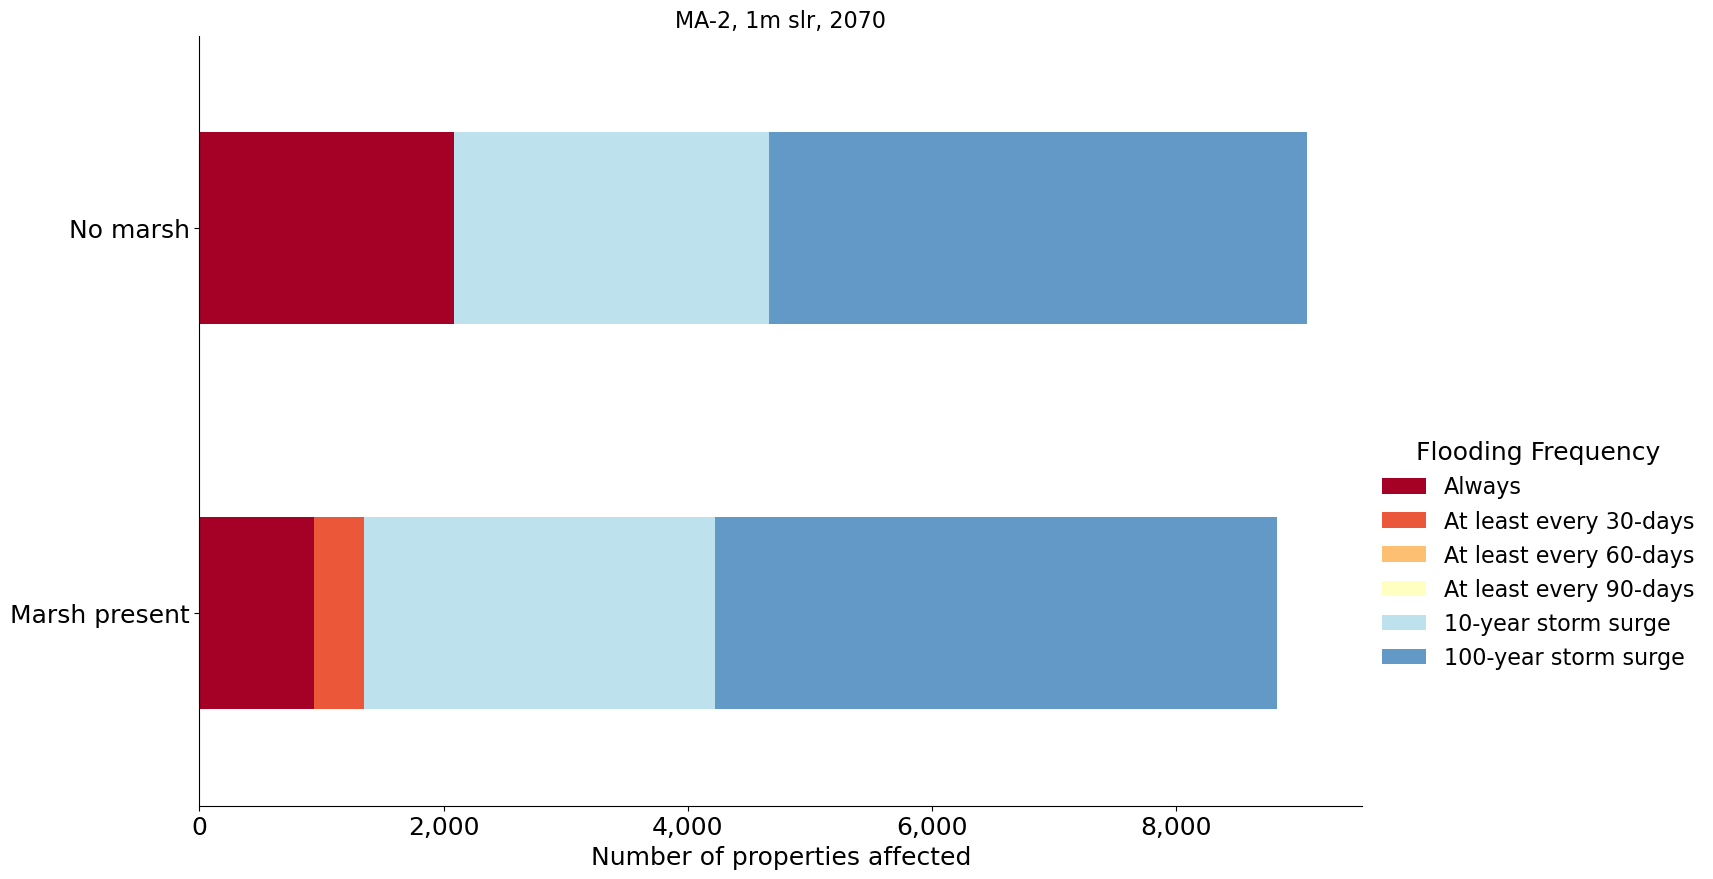

In [72]:
wanted_plt = plot_stack_bar(marsh_wanted, 
                                'num_props_affect', 
                                'MA-2, 1m slr, 2070', 
                                'Number of properties affected',
                                OUTPUT + 'ma2/ma2_1slr_70_homes.png'
                                )